<a href="https://colab.research.google.com/github/ramjv/RCNN/blob/master/RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

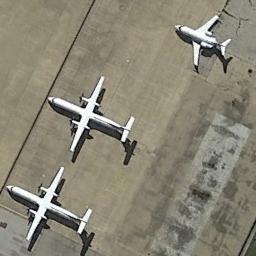

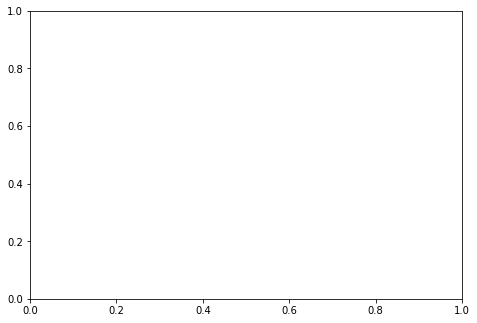

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import csv
from csv import reader
import pandas as pd
from matplotlib import patches
%matplotlib inline
from google.colab.patches import cv2_imshow

df = pd.read_csv("/content/sample_data/airplane.csv")
img = cv2.imread("/content/airplane_001.jpg")
cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
for _,row in df[df.image_names == "airplane_001.jpg"].iterrows():
    xmin = row.x1
    xmax = row.x2
    ymin = row.y1
    ymax = row.y2

    width = xmax - xmin
    height = ymax - ymin

    rect = patches.Rectangle((xmin, ymin), width, height, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
cv2_imshow(img)



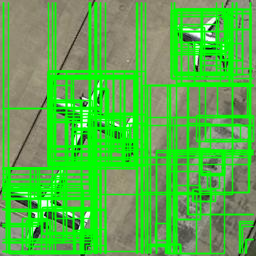

In [2]:
cv2.setUseOptimized(True)
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
im = cv2.imread("/content/airplane_001.jpg")
ss.setBaseImage(im)
ss.switchToSelectiveSearchFast()
rects = ss.process()
imOut = im.copy()
for i, rect in (enumerate(rects)):
    x, y, w, h = rect
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
cv2_imshow(imOut)

In [0]:
train_images=[]
train_labels=[]

def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [4]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

for e,i in enumerate(os.listdir("/content/")):
    try:
        if e < 3  and i.startswith("airplane"):
            print(e,"------",i)
            image = cv2.imread("/content/"+i)
            df = pd.read_csv("/content/sample_data/airplane.csv")
            gtvalues=[]
            for row in df[df.image_names == i].itertuples():
                x1 = row.x1
                x2 = row.x2
                y1 = row.y1
                y2 = row.y2
                gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
            print("*****************")
            ss.setBaseImage(image)
            ss.switchToSelectiveSearchFast()
            ssresults = ss.process()
            imout = image.copy()
            counter = 0
            falsecounter = 0
            flag = 0
            fflag = 0
            bflag = 0
            for e,result in enumerate(ssresults):
                if e < 2000 and flag == 0:
                    for gtval in gtvalues:
                        x,y,w,h = result
                        iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                        if counter < 30:
                            if iou > 0.70:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(1)
                                counter += 1
                        else :
                            fflag =1
                        if falsecounter <30:
                            if iou < 0.3:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(0)
                                falsecounter += 1
                        else :
                            bflag = 1
                    if fflag == 1 and bflag == 1:
                        print("inside")
                        flag = 1
    except Exception as e:
        print(e)
        print("error in " + i)
        continue
X_new = np.array(train_images)
y_new = np.array(train_labels)

print(X_new.shape)
print(y_new.shape)

1 ------ airplane_188.jpg
*****************
2 ------ airplane_606.jpg
*****************
(72, 224, 224, 3)
(72,)


In [5]:
import tensorflow
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16

vggmodel = VGG16(weights='imagenet', include_top=True)
vggmodel.summary()

for layers in (vggmodel.layers)[:15]:
    print(layers)
    layers.trainable = False

X= vggmodel.layers[-2].output

predictions = Dense(2, activation="softmax")(X)

model_final = Model(vggmodel.input,predictions)

from tensorflow.keras.optimizers import Adam
opt = Adam(lr=0.0001)

model_final.compile(loss = keras.losses.categorical_crossentropy, optimizer = opt, metrics=["accuracy"])

model_final.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [6]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

class MyLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y
    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)

lenc = MyLabelBinarizer()
Y =  lenc.fit_transform(y_new)

X_train, X_test , y_train, y_test = train_test_split(X_new,Y,test_size=0.10)

print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

trdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
traindata = trdata.flow(x=X_train, y=y_train)
tsdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
testdata = tsdata.flow(x=X_test, y=y_test)

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("air_rcnn_vgg16_1.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

hist = model_final.fit_generator(generator= traindata, steps_per_epoch= 10, epochs= 5, validation_data= testdata, validation_steps=2, callbacks=[checkpoint,early])



(64, 224, 224, 3) (8, 224, 224, 3) (64, 2) (8, 2)
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
10/10 [==============================] - ETA: 0s - loss: 0.9871 - accuracy: 0.8469
Epoch 00001: val_loss improved from inf to 0.10672, saving model to air_rcnn_vgg16_1.h5
10/10 [==============================] - 11s 1s/step - loss: 0.9871 - accuracy: 0.8469 - val_loss: 0.1067 - val_accuracy: 0.9375
Epoch 2/5
10/10 [==============================] - ETA: 0s - loss: 0.1139 - accuracy: 0.9500
Epoch 00002: val_loss did not improve from 0.10672
10/10 [==============================] - 4s 430ms/step - loss: 0.1139 - accuracy: 0.9500 - val_loss: 0.1831 - val_accuracy: 0.9375
Epoch 3/5
10/10 [==============================] - ETA: 0s - loss: 0.0445 - accuracy: 0.9812
Epoch 00003: val_loss did not improve from 0.10672
10/10 [==============================] - 4s 413ms/step - loss: 0.0445 - accuracy: 0.9812 - val_loss: 0.3091 - val_accuracy: 0.9375
Epoch 4/5
10/1